In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, VGG19

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd gdrive/MyDrive/cpe_695

/content/gdrive/MyDrive/cpe_695


In [5]:
ls

 Feature_extraction.ipynb         transfer_learning.ipynb
'Load in data and labels.ipynb'   transfer_learning_newdata.ipynb
 network_performance.ipynb        Untitled0.ipynb
'Notes Tasks Meetings:.gdoc'      X.pickle
 original_images/                 xrays/
 prelim_results.ipynb             y.pickle


In [6]:
TRAINDIR = "original_images"

In [7]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)


In [8]:
IMG_H = 224
IMG_W = 224
batch_size=12

In [9]:
train_generator = train_datagen.flow_from_directory(TRAINDIR,
                                                    target_size=(IMG_H, IMG_W),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

Found 304 images belonging to 3 classes.


In [65]:
train_generator.class_indices.keys()

dict_keys(['No_findings', 'Pneumonia', 'covid19'])

In [10]:
validation_generator = train_datagen.flow_from_directory(TRAINDIR,
                                                         target_size=(IMG_H, IMG_W),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 76 images belonging to 3 classes.


In [11]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))

#Freeze the base models
vgg16_base.trainable = False
vgg19_base.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [12]:
# Extract features from the train generator using VGG16
train_features = np.zeros(shape=(304, 7, 7, 512))
train_labels = np.zeros(shape=(304, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in train_generator:
  features_batch = vgg16_base.predict(inputs_batch)
  train_features[i * batch_size: (i+1) * batch_size] = features_batch
  train_labels[i * batch_size: (i+1) * batch_size] = labels_batch
  i += 1
  if i*batch_size >= 304:
    break

In [13]:
train_features.shape

(304, 7, 7, 512)

In [14]:
train_labels.shape

(304, 3)

In [64]:
train_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1

In [15]:
# Extract features from validation generator using VGG16
val_features = np.zeros(shape=(76, 7, 7, 512))
val_labels = np.zeros(shape=(76, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in validation_generator:
  features_batch = vgg16_base.predict(inputs_batch)
  val_features[i * batch_size: (i+1) * batch_size] = features_batch
  val_labels[i * batch_size: (i+1) * batch_size] = labels_batch
  i += 1
  if i*batch_size >= 76:
    break

In [16]:
val_features.shape

(76, 7, 7, 512)

In [17]:
val_labels.shape

(76, 3)

# VGG16 Performance

In [18]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.add(layers.Dense(4096))
model.add(layers.Dense(1000))
model.add(layers.Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(train_features, train_labels, batch_size=30, epochs=20, validation_data=(val_features, val_labels))

Epoch 1/20
11/11 [==============================] - 8s 757ms/step - loss: 644.5231 - accuracy: 0.3849 - val_loss: 410.9270 - val_accuracy: 0.3684
Epoch 2/20
11/11 [==============================] - 8s 736ms/step - loss: 210.0848 - accuracy: 0.4145 - val_loss: 56.9608 - val_accuracy: 0.3684
Epoch 3/20
11/11 [==============================] - 8s 737ms/step - loss: 21.0037 - accuracy: 0.6118 - val_loss: 55.9455 - val_accuracy: 0.6184
Epoch 4/20
11/11 [==============================] - 8s 733ms/step - loss: 9.0777 - accuracy: 0.8717 - val_loss: 21.7961 - val_accuracy: 0.6974
Epoch 5/20
11/11 [==============================] - 8s 739ms/step - loss: 5.4107 - accuracy: 0.8816 - val_loss: 26.3909 - val_accuracy: 0.7763
Epoch 6/20
11/11 [==============================] - 8s 731ms/step - loss: 2.3028 - accuracy: 0.9342 - val_loss: 3.6413 - val_accuracy: 0.9079
Epoch 7/20
11/11 [==============================] - 8s 721ms/step - loss: 0.7523 - accuracy: 0.9704 - val_loss: 6.0342 - val_accuracy: 0.

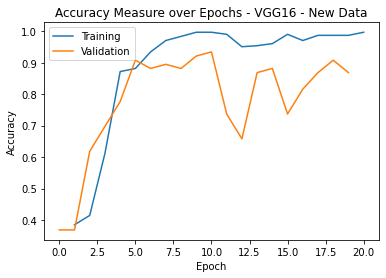

In [19]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,21)]
plt.plot(epochs, hist.history['accuracy'], hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs - VGG16 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

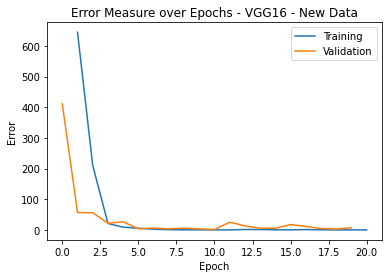

In [20]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG16 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

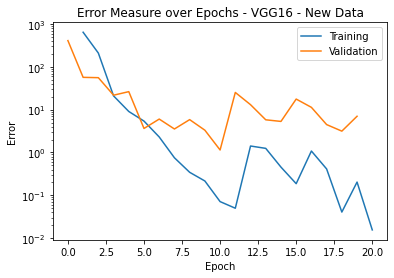

In [21]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG16 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [22]:
pred_train = model.predict(train_features)

In [25]:
pred_test = model.predict(val_features)

In [40]:
#convert softmax probability output into single vector containing class labels for each instance
y_train_16 = np.argmax(train_labels, axis=1)

In [41]:
y_train_16.shape

(304,)

In [42]:
y_pred_train_16 = np.argmax(pred_train, axis=1)
y_pred_train_16.shape

(304,)

Accuracy on training set:  1.0


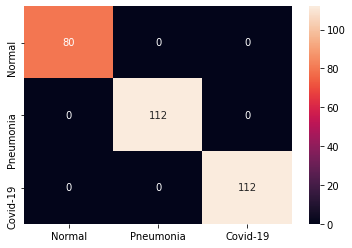

In [66]:
from sklearn import metrics 
print('Accuracy on training set: ',metrics.accuracy_score(y_train_16, y_pred_train_16))

from sklearn.metrics import confusion_matrix
import seaborn as sns

categories = ['Normal', 'Pneumonia', 'Covid-19']
cm = confusion_matrix(y_train_16, y_pred_train_16)
sns.heatmap(cm, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')


Accuracy on Test Set:  0.868421052631579


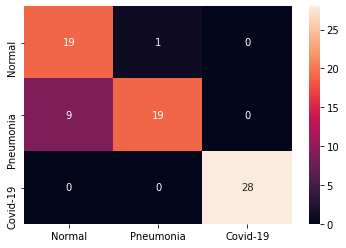

In [67]:
# Accuracy and Confusion Matrix for test set

#convert softmax probability output into single vector containing class labels for each instance
y_test_16 = np.argmax(val_labels, axis=1)
y_pred_test_16 = np.argmax(pred_test, axis=1)

print('Accuracy on Test Set: ', metrics.accuracy_score(y_test_16, y_pred_test_16))

cm_test = confusion_matrix(y_test_16, y_pred_test_16)
sns.heatmap(cm_test, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')

# Now with VGG 19

In [46]:
# Extract features from the train generator using VGG19
train_features_19 = np.zeros(shape=(304, 7, 7, 512))
train_labels_19 = np.zeros(shape=(304, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in train_generator:
  features_batch = vgg19_base.predict(inputs_batch)
  train_features_19[i * batch_size: (i+1) * batch_size] = features_batch
  train_labels_19[i * batch_size: (i+1) * batch_size] = labels_batch
  i += 1
  if i*batch_size >= 304:
    break

In [47]:
train_features_19.shape

(304, 7, 7, 512)

In [48]:
train_labels_19.shape

(304, 3)

In [49]:
# Extract features from validation generator using VGG19
val_features_19 = np.zeros(shape=(76, 7, 7, 512))
val_labels_19 = np.zeros(shape=(76, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in validation_generator:
  features_batch = vgg19_base.predict(inputs_batch)
  val_features_19[i * batch_size: (i+1) * batch_size] = features_batch
  val_labels_19[i * batch_size: (i+1) * batch_size] = labels_batch
  i += 1
  if i*batch_size >= 76:
    break

In [50]:
val_features_19.shape

(76, 7, 7, 512)

In [51]:
val_labels_19.shape

(76, 3)

In [52]:

model_19 = models.Sequential()
model_19.add(layers.Flatten())
model_19.add(layers.Dense(4096))
model_19.add(layers.Dense(4096))
model_19.add(layers.Dense(1000))
model_19.add(layers.Dense(3, activation="softmax"))
model_19.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist_19 = model_19.fit(train_features_19, train_labels_19, batch_size=30, epochs=20, validation_data=(val_features_19, val_labels_19))

Epoch 1/20
11/11 [==============================] - 9s 838ms/step - loss: 808.4556 - accuracy: 0.3421 - val_loss: 327.8210 - val_accuracy: 0.3684
Epoch 2/20
11/11 [==============================] - 8s 698ms/step - loss: 225.1567 - accuracy: 0.4474 - val_loss: 26.8364 - val_accuracy: 0.5658
Epoch 3/20
11/11 [==============================] - 8s 704ms/step - loss: 38.2994 - accuracy: 0.7368 - val_loss: 49.4947 - val_accuracy: 0.7632
Epoch 4/20
11/11 [==============================] - 8s 717ms/step - loss: 21.4662 - accuracy: 0.8586 - val_loss: 81.5900 - val_accuracy: 0.6974
Epoch 5/20
11/11 [==============================] - 8s 715ms/step - loss: 15.0925 - accuracy: 0.8816 - val_loss: 80.3919 - val_accuracy: 0.6316
Epoch 6/20
11/11 [==============================] - 8s 739ms/step - loss: 6.1555 - accuracy: 0.9441 - val_loss: 48.6604 - val_accuracy: 0.7763
Epoch 7/20
11/11 [==============================] - 8s 703ms/step - loss: 12.9242 - accuracy: 0.9375 - val_loss: 3.8747 - val_accuracy

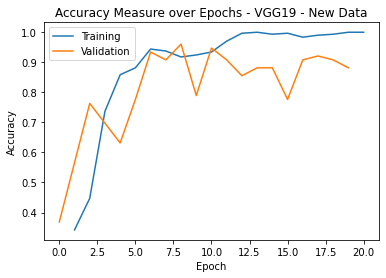

In [53]:
epochs = [i for i in range(1,21)]
plt.plot(epochs, hist_19.history['accuracy'], hist_19.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs - VGG19 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

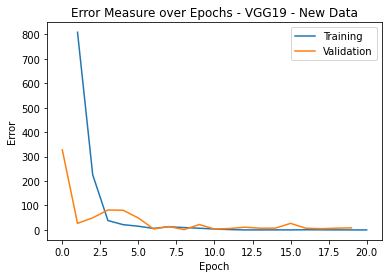

In [54]:
plt.plot(epochs, hist_19.history['loss'], hist_19.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG19 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

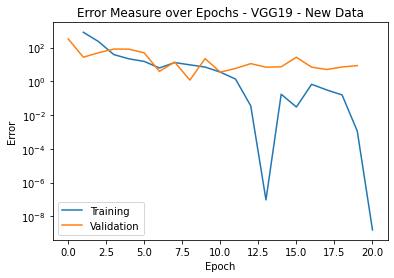

In [55]:
plt.plot(epochs, hist_19.history['loss'], hist_19.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs - VGG19 - New Data')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [56]:
#get softmax outputs
pred_train_19 = model_19.predict(train_features_19)
pred_test_19 = model_19.predict(val_features_19)

#convert softmax outputs into vector outputs for metrics
y_train_19 = np.argmax(train_labels_19, axis=1)
y_pred_train_19 = np.argmax(pred_train_19, axis=1)
y_test_19 = np.argmax(val_labels_19, axis=1)
y_pred_test_19 = np.argmax(pred_test_19, axis=1)


Accuracy on Train Set:  1.0


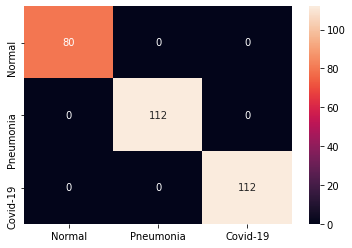

In [68]:
# Accuracy Score and Confusion Matrix

print('Accuracy on Train Set: ', metrics.accuracy_score(y_train_19, y_pred_train_19))

cm_train_19 = confusion_matrix(y_train_19, y_pred_train_19)
sns.heatmap(cm_train_19, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')

Accuracy on Test Set:  0.881578947368421


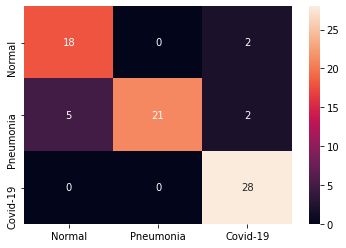

In [69]:
print('Accuracy on Test Set: ', metrics.accuracy_score(y_test_19, y_pred_test_19))

cm_test_19 = confusion_matrix(y_test_19, y_pred_test_19)
sns.heatmap(cm_test_19, xticklabels=categories, yticklabels=categories, annot=True, fmt='d')